# Vehicle Detection Project #

## Goals and Deliverables ##

In this project we will:

1. We will train a Linear Support Vector Machine (SVM) classier using labeled training sets of Vehicle and Non-Vehicle images.
2. We will apply a color transform on the labeled images and then extract the following feature for this training:
a. Histogram of Oriented Gradients (HOG) 
b. Histogram of Colors and
c. Spatial Binning
3. The combined feature-set will be normalized. Of course we will need to do this normalization not only during training but also during test.
4. The available labeled data will be randomized for training and test.
5. Once the predictors are created, for vehicle detection in the image,  we will implement a sliding window technique and use our trained classifiers to search for vehicles in images.
6. We will then implement an optimization where we will extract HOG features just once for the entire region of interest in each full image or  video frame and then sub-sample that array for each sliding window. In order to have multiple sizes of the sliding window, we will run this detection once with the whole image scaled by factor of 1 and then scaled by a factor of 1.5.fwill apply a heat-map technique where the pixel in each detected bounding box has its quantity incremented. Then we will apply a thresholding technique which will help remove the transient false positives. Using the label utility library in python we will identify distinct objects in the heatmap and then draw bounding rectangles that will then be superimposed on the image.
8. We will run our pipeline on a video stream. To address the false positive issue further we will compute the heat map over the last 5 frames and sum them together to create the bounding rectangles.

Please **note** - A lot of the functions in this assignment are taken from the lectures on Vehicle Detection at Udacity and the TA Session on Vehicle Detection Walkthrough on Feb 10.

In [1]:
import os.path
import fnmatch
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
import glob
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
%matplotlib inline

## Data Exploration ##
Let us read in the set of Cars from GTI vehicle database and KITTI vision benchmark suite and Non Cars images. The goodness is that the cars and non cars are roughly well balanced. 

In addition for visualization we write a simple helper function and use it to see some images.

In [2]:
# Plot Multiple Images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])           

In [3]:
# Read in cars and notcars
path = './vehicles'
cars = [os.path.join(dirpath, f)
        for dirpath, dirnames, files in os.walk(path)
        for f in fnmatch.filter(files, '*.png')]

path = './non-vehicles'
notcars = [os.path.join(dirpath, f)
           for dirpath, dirnames, files in os.walk(path)
           for f in fnmatch.filter(files, '*.png')]

print("Read in ", len(cars), " cars ")
print("Read in ", len(notcars), " not cars")

Read in  8792  cars 
Read in  8968  not cars


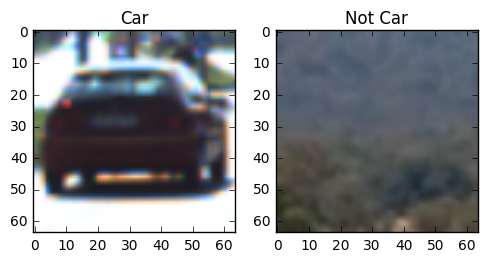

In [12]:
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])
images = [car_image, notcar_image]
titles = ['Car',"Not Car"]
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)

## Histogram of Oriented Gradients ##

Navneet Dalal's research at INRIA on Human Detection in Images (and subsequently other objects) showed that Histogram of Object Gradients as features for a linear classifier like SVM very effective in detecting humans/objects. The 
parameters to choose are orientations, pixels_per_cell, and cells_per_block). 

Navneet's paper recommends that with more than 9 orientations, the effectiveness of the HOG feature selection begins to wane. The lecture suggested 8 pixels per-cell as a standard size to capture the feature and 2 cells per block.

In order to get a feel for HOG features on Cars and Non-Cars let us use the scikit function hog and visualize them. It is visually clear that Cars and Non-Cars have distinct Hog features.

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(
                                      cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False,
                       visualise=vis, feature_vector=feature_vec)
        return features

In [6]:
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
orient = 9  # HOG orientations

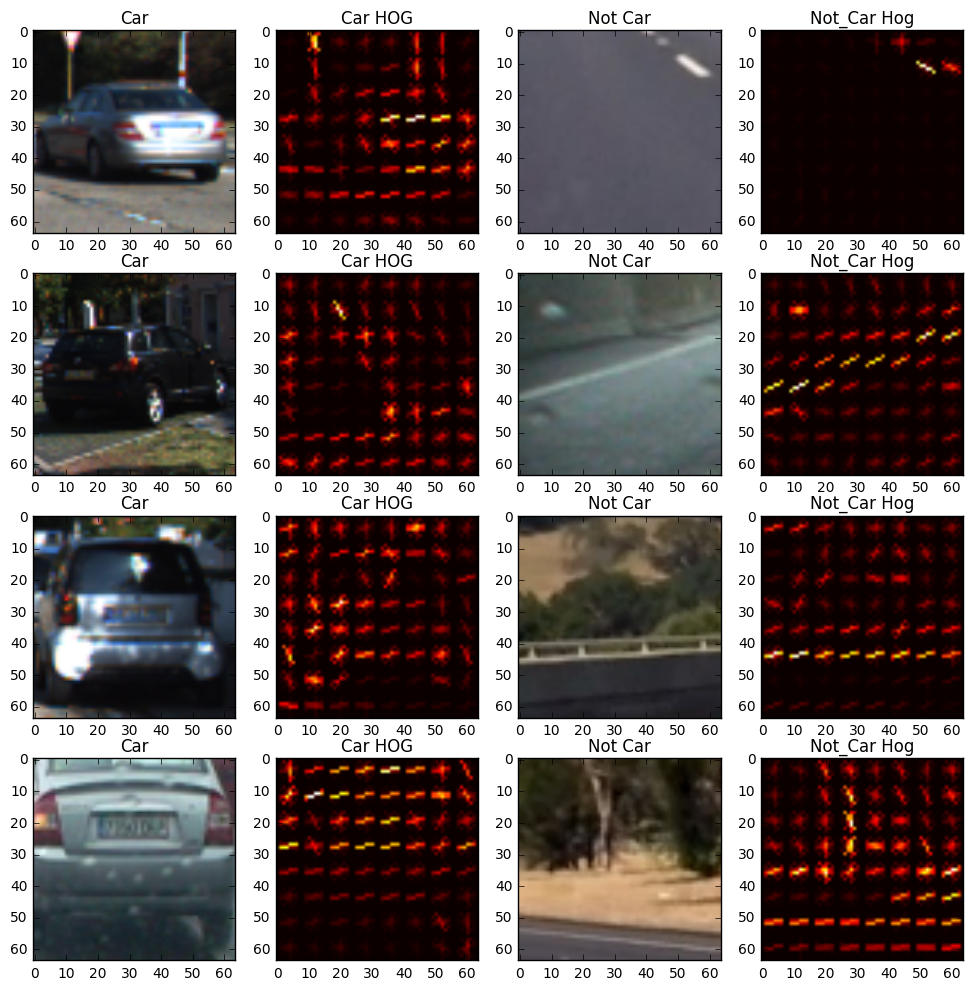

In [7]:
images = []
titles = []
for x in range(4):
    car_ind = np.random.randint(0, len(cars))
    notcar_ind = np.random.randint(0, len(notcars))
    car_image = mpimg.imread(cars[car_ind])
    notcar_image = mpimg.imread(notcars[notcar_ind])
    gray_car_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
    fcar, car_hog_image = get_hog_features(gray_car_image, orient, pix_per_cell, cell_per_block,
                         vis=True, feature_vec=True)
    gray_notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY)
    fnotcar, notcar_hog_image = get_hog_features(gray_notcar_image, orient, pix_per_cell, cell_per_block,
                         vis=True, feature_vec=True)
    imgs = [car_image, car_hog_image, notcar_image, notcar_hog_image]
    titls = ["Car", "Car HOG", "Not Car", "Not_Car Hog"]
    images.extend(imgs)
    titles.extend(titls)

fig = plt.figure(figsize=(12,12))
visualize(fig, 4, 4, images, titles)

## Feature Selection for Object Detection using `extract_features` ##

For more effective object detection we do not just rely on Object Gradient as a feature `get_hog_features` but also leverage the color-based features. For the color based features we look at the histogram of color intensities and the spatial binning of the color. Even when we resize the car images to (32, 32) size the shape of the care is still identifiable. 

Hence for more effective object detection, we combine the color-based features [`bin_spatial` and `color_hist`] and the gradient-based HOG features. In terms of color-space choice, gradients are best expressed in **YCbCr** color space. We noticed that HSV performed than RGB and upon recommendation by TA **YCbCr** proved to be even more effective.

After the color and gradient based features are combined, we normalize them. We note that both during image training and testing we have to be careful that we build the features in the same order and normalize them.

In [8]:
# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:, :, 0], size).ravel()
    color2 = cv2.resize(img[:, :, 1], size).ravel()
    color3 = cv2.resize(img[:, :, 2], size).ravel()
    return np.hstack((color1, color2, color3))


# Define a function to compute color histogram features
# We do not need to pass in the bins_range argument. Causes issues with
# reading .png files with mpimg!
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate(
        (channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [9]:
# Define a function to extract features from a list of images
# Have this function call get_hog_features() bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Sliding Window Implementation for Object Detection ##
### Sliding Windows ###
Now that we have implemented functions to extract classifiers and features, let us implement a sliding window function `slide_window` that will scan an image, extract sliding windows. In each of these windows we will look whether the window image is a car or not based on our trained classifier. We test our implemenation of sliding windows on a test image with a window size of (128,128).

In [13]:
# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0] * (xy_overlap[0]))
    ny_buffer = np.int(xy_window[1] * (xy_overlap[1]))
    nx_windows = np.int((xspan - nx_buffer) / nx_pix_per_step)
    ny_windows = np.int((yspan - nx_buffer) / ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

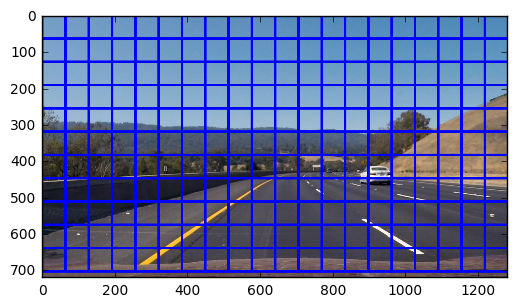

In [14]:
img_src = 'test_images/test3.jpg'
image = mpimg.imread(img_src)
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

### Search for Car in Sliding Windows ###`

The following helper functions implement the test/application of the learned features.

* `single_img_features` works similar to `extract_features` but extracts features for a single image for evaluation/prediction.
* `search_windows` invokes `extract_features` on the test image, normalizes/scales the features and invokes the trained SVM for the prediction. If the prediction results in a positive results, it saves that window as one where a car was detected.

In [20]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # 1) Define an empty list to receive features
    img_features = []
    # 2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    # 3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # 4) Append features to list
        img_features.append(spatial_features)
    # 5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # 6) Append features to list
        img_features.append(hist_features)
    # 7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # 8) Append features to list
        img_features.append(hog_features)

    # 9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32, orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):

    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    # 2) Iterate over all windows in the list
    for window in windows:
        # 3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[
                              0][0]:window[1][0]], (64, 64))
        # 4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        # 5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # 6) Predict using your classifier
        prediction = clf.predict(test_features)
        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # 8) Return windows for positive detections
    return on_windows

## Model Training with Parameter Selection ##

Let us now use the above extract_features to train classifiers and extract features on the cars and not_cars images. As discussed above we will normalize the features extracted. We use scikit's train_test_split to randomly split the data into train and test sets and then train and test the SVM classifier.

The following are the parameters selected for training and evaluation of the model.

1. **Color Space** : As mentioned above we change the image's color space to YCbCr - this color space helps to best extract the image gradient and then build up the histogram of oriented gradients.

2. **Spatial Size**: For color features the spatial size selected is (32, 32). With a (32, 32) image we still are able to discern the image of a car. This increases the feature size (say as compared to (16, 16).

3. **Number of Histogram Bins**: 32 - For histogram of color features let us use the number of histogram bins as 32.

4. Our classifier will be built to extract the **HOG features**, the **spatial_binning** and the **color_histogram**

5. Our sliding window will move forward with 0.5 overlap of the previous window.

The selection of the above parameters (Spatial Size, Histogram Bins, feature selection) impact the length of the Feature Vector - *8460*. This impacts the evaluation/prediction/classification time.

In [16]:
# Parameters for Training and Test of Images
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel = 'ALL'  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off
y_start_stop = [400, 656]  # Min and max in y to search in slide_window()
overlap = 0.5

In [17]:
car_features = extract_features(cars, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space,
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel, spatial_feat=spatial_feat,
                                   hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell,
      'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
7.45 Seconds to train SVC...
Test Accuracy of SVC =  0.9932


## Evaluation of the Learned Model ###

** Parameter Selection **

In order to avoid detecting images on the sky and high on the trees let us run our sliding window detection not along the complete height of the image but restrict it avoid the sky and the camera's dashboard. While it might imply that cars further off might miss detection, they are sufficiently further away and will come closer into view as the car moves forward. Hence we restrict the *y dimension*/*vertical region of image* scanning from 400 to 656. 

For our sliding window implementation we first pick a *(128, 128) sized window*. The goal is to have a window size big enough to capture the closer cars. Our sliding window implementation should also run the sliding window scan with smaller sized windows. In our subsequent implementation below, we will also *effectively* pick multiple sized windows (by scaling down the main image).

For the sliding window we use an overlap of 0.5 as slide the window forward.

In [18]:
# Consider a narrower swath in y
ystart = 400
ystop = 656

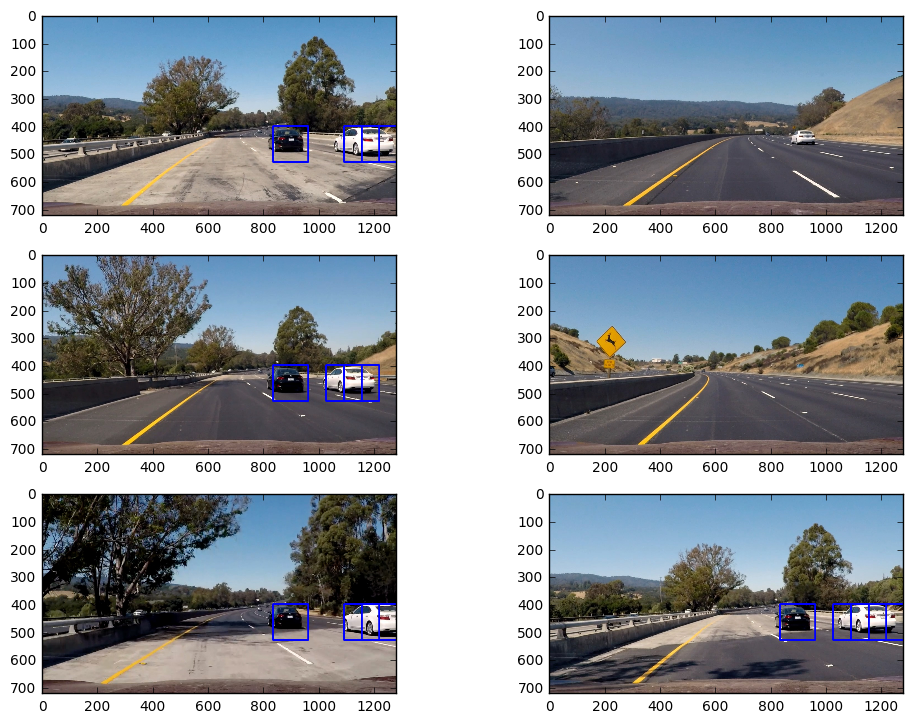

In [21]:
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [ystart, ystop] # Min and Max in y to search in slide window()
overlap = 0.5
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    #print(np.min(img), np.max(img))
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                          xy_window=(128,128), xy_overlap = (overlap, overlap))
    
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)

    window_img = draw_boxes(draw_img, hot_windows, color=(0,0,255), thick=6)
    images.append(window_img)
    titles.append('')
    #print(time.time()-t1, 'seconds to process one image search', len(windows), 'windows')
fig = plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 6,2, images, titles)

**Assessment**
On our test images the sliding window implementation performed rather well. There are no false positives. On the image where there is no car, no false positive is detect. On image two because the car is past the sliding window search space, it is not detected. On test images 4 and 6 we see multiple bounding boxes on the same car.

** Overlapping Windows and False Positives remedy with Thresolded Heat Maps **
In order to avoid potential false positives and multiple bounding boxes, let us take a heat map approach and draw a bounding box around the heat-maps that exceed a certain threshold. Let us implement and evaluate the heat-map approach next.

In [22]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)),
                (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
    # Return the image
    return img

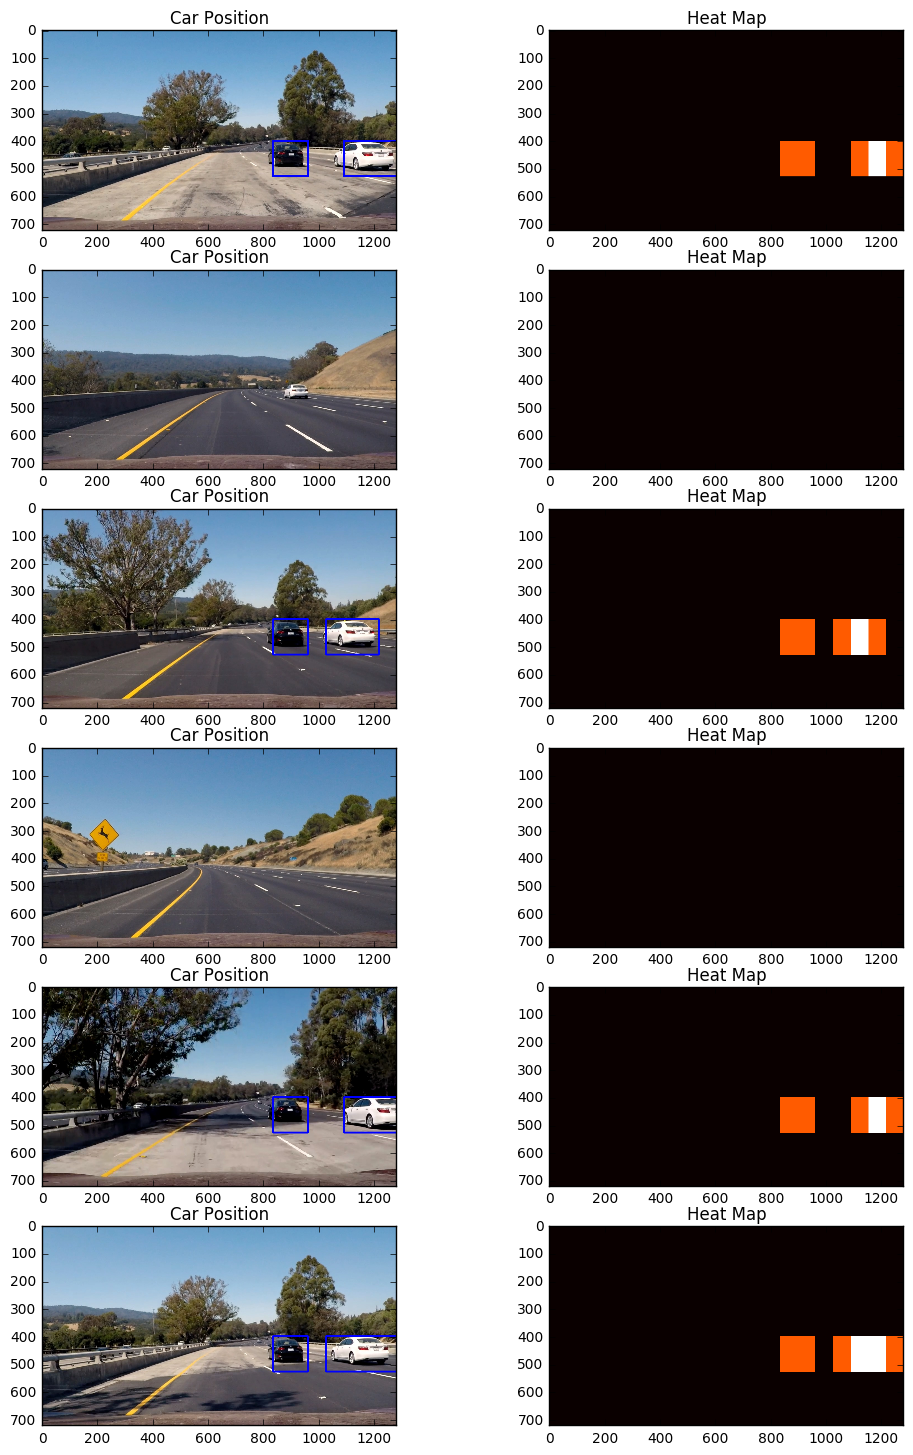

In [23]:
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
images = []
titles = []
out_maps = []
out_boxes = []
y_start_stop = [400, 656] # Min and Max in y to search in slide window()
overlap = 0.5

for img_src in example_images:

    img = mpimg.imread(img_src)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                          xy_window=(128,128), xy_overlap = (overlap, overlap))
    
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
    
    heat = add_heat(heat, hot_windows)
    heatmap = np.clip(heat, 0, 255)
    
    labels = label(heatmap)
    window_img = draw_labeled_bboxes(draw_img, labels)
    
    images.append(window_img)
    titles.append('Car Position')
    
    images.append(heatmap)
    titles.append('Heat Map')

fig = plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 6,2, images, titles)

## Hog Sub-sampling Window Search ##

The above sliding window implementation is not performance optimal. A more efficient implementation **find_cars** (below) allows us to only have to extract the Hog features once for the region of interest for the image.

**find_cars** extract-s hog features once and then sub-samples it to get all of the overlaying windows. Each window is characterized by a scaling factor. To capture the car images of different sizes we apply multiple scaling factors 1 and 1.5. Rather than apply different window-sizes of say (128, 128) [our training windows were of size (64,64)], we scale the entire image, apply hog-extraction to it and then sub-sample it with the effect that it re-samples it with a different window size to detect cars of smaller size.

This function is used to both extract features and make predictions.

In [24]:
scale = 1.5

In [25]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [26]:
def find_cars(img, scale, heatmap):
    pix_per_cell = 8
    cell_per_block = 2

    img_boxes = []
    t = time.time()
    count = 0
    draw_img = np.copy(img)
    # Make a heatmap of zeros
    img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch,
                                     (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG featres for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell,
                            cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell,
                            cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell,
                            cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window,
                             xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window,
                             xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window,
                             xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(
                ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get the color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart),
                              (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0, 0, 255))
                img_boxes.append(((xbox_left, ytop_draw + ystart),
                                  (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                heatmap[ytop_draw + ystart:ytop_draw + win_draw +
                        ystart, xbox_left:xbox_left + win_draw] += 1

    #print(time.time() - t, 'seconds to run, total windows = ', count)

    return draw_img, heatmap


## Video Implementation ##

Let us now apply our `find_cars` to the project video and evaluate it. `process_image` will take each frame/image and apply feature-extraction and object prediction on it.

### On top of that we applied ##

#### Multiple Scaling Factors on the same image ####
We apply scale of 1.0 and 1.5 and add the heatmap results for each pixel.

#### Smoothing heat-maps across multiple images ####
We sum the heat-maps across the last **5** images to smooth out the result detection.

#### Apply a Thresholding (at least 2) to the heat-map ####
In order to **remove the false positives** (false positives popping up in a single frame)** we apply a threshold filter of 2**.


In [27]:
import collections
heat_map_deque=collections.deque()

In [28]:
def process_image(img):
    heatmap=np.zeros_like(img[:, :, 0])
    out_img, heatmap=find_cars(img, 1.0, heatmap)
    out_img, heat_map=find_cars(img, 1.5, heatmap)
    heat_map_deque.append(heat_map)
    use_heat_map=heat_map
    if (len(heat_map_deque) > 5):
        heat_map_deque.popleft()
        for i in range(5):
            hmap=heat_map_deque[i]
            use_heat_map=use_heat_map + hmap
    use_heat_map = apply_threshold(use_heat_map, 2)
    labels=label(use_heat_map)
    # Draw bounding boxes on a copy of the image
    draw_img=draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [29]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
test_output='result_of_project_video.mp4'
clip1=VideoFileClip('project_video.mp4', audio = False)
test_clip=clip1.fl_image(process_image)
%time test_clip.write_videofile(test_output, audio = False)

[MoviePy] >>>> Building video result_of_project_video.mp4
[MoviePy] Writing video result_of_project_video.mp4


100%|█████████▉| 1260/1261 [25:11<00:01,  1.21s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_of_project_video.mp4 

CPU times: user 26min 20s, sys: 3.67 s, total: 26min 24s
Wall time: 25min 11s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output))

**Assesment** We able to detect and follow the white car across multiple frames. There were a few transient false positives on the road-surface.

** Future Improvements ** 
1. Try a more comprehensive examination of the potential scale factort(different window-sizes) and different overlaps to better pick up cars of different sizes (we currently use two).
2. Use the additional training data from Udacity to train on more data. 
3. Note the non-images training data was tested on the project video. This helped enforce the 'avoidance' of false-positives non-car images in this project video. We will evaluate how it performs on the other challenge-videos.
4. Instead of simple SVM Linear Classifier, look into using Deep Learning techniques for the object classification exercise.